In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
def testscore(predtmp,oritmp):
    score=1
    pred=np.ravel(predtmp)
    ori=np.ravel(oritmp)
    n=0
    for i in range(len(pred)):
        if ori[i]!=0:
            n=n+1
    print(n)
    for i in range(len(pred)):
        if ori[i]!=0:
            score=score-1/n*abs(pred[i]-ori[i])/abs(ori[i])
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('score:')
    print(score)
    return score

In [3]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C4_12')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)

dt=t[1]-t[0]
t=t[80:120]


In [4]:



spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T
'''
print('spatial_grid')
print(spatial_grid.shape)
print(spatial_grid)
'''

n=25

u=np.zeros((n,n,121, 2))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=u[:,:,80:120,:]
u_up=u_train
u_up[:,:n-1,:,:]=u_train[:,1:,:,:]
u_up[:,n-1,:,:]=u_train[:,0,:,:]
'''
u_train[:, :, :, 0] = x
u_train[:, :, :, 1] = y
'''
u_dot_train = ps.FiniteDifference(axis=2)._differentiate(u_train, dt)
#print(u_dot_train[10,10])
tmp=u_train+u_dot_train*dt
testscore(tmp[:,:,:len(t)-1],u_train[:,:,1:])
#testscore(u_dot_train,u_test)

24090
score:
-2.625764041037942


-2.625764041037942

In [5]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('u_train')
print(u_train.shape)



'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_train)
'''
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, x_dot=u_dot_train)
model.print()
'''
print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, t=dt)
model.print()


print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)

model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train)
model.print()'''

u_train
(25, 25, 40, 2)
STLSQ model: 
(Vx)' = 30.073 1 + 57.876 Vx + -17.753 Vy + -2.532 VxVxVx + 0.119 VyVyVy + -1.961 VxVyVy + 1.816 VxVxVy + 74.497 Vx_2 + 164.175 Vy_2 + 349.199 Vx_22 + 9.112 Vy_22 + -126.857 Vx_1 + -66.077 Vy_1 + 623.169 Vx_12 + 402.719 Vy_12 + 166.484 Vx_11 + 32.575 Vy_11 + -89.579 VxVx_2 + 27.489 VxVy_2 + -0.452 VyVx_2 + -1.130 VyVy_2 + 4.699 VxVxVxVx_2 + -2.345 VxVxVxVy_2 + -54.264 VyVyVyVx_2 + 4.477 VyVyVyVy_2 + -0.474 VxVyVyVx_2 + 0.244 VxVyVyVy_2 + 1.181 VxVxVyVx_2 + -8.660 VxVxVyVy_2 + -108.587 VxVx_22 + 15.245 VxVy_22 + 4.502 VyVx_22 + -3.148 VyVy_22 + 7.142 VxVxVxVx_22 + -7.405 VxVxVxVy_22 + -420.502 VyVyVyVx_22 + 48.495 VyVyVyVy_22 + 12.879 VxVyVyVx_22 + 0.204 VxVyVyVy_22 + 5.544 VxVxVyVx_22 + -0.082 VxVxVyVy_22 + -52.523 VxVx_1 + 76.032 VxVy_1 + -0.667 VyVx_1 + -1.065 VyVy_1 + -0.046 VxVxVxVx_1 + -0.696 VxVxVxVy_1 + 13.763 VyVyVyVx_1 + 16.774 VyVyVyVy_1 + -2.569 VxVyVyVx_1 + -0.960 VxVyVyVy_1 + 1.071 VxVxVyVx_1 + 1.296 VxVxVyVy_1 + 694.176 VxVx_12 + -532

"\nprint('SR3 model, L0 norm: ')\noptimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,\n                   thresholder='l0', normalize_columns=True)\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])\nmodel.fit(u_train, t=dt)\nmodel.print()\n\n\nprint('SR3 model, L1 norm: ')\noptimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,\n                   thresholder='l1', normalize_columns=True)\n\nmodel = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)\nmodel.fit(u_train, x_dot=u_dot_train)\nmodel.print()"

In [6]:
t_test=np.arange(0,25,1)
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(u_train)
print(x_dot_test_predicted.shape)
#print(x_dot_test_predicted[0])
#print(x_dot_test_predicted.shape)
dottmp=np.array(x_dot_test_predicted)
pltpredict=u_train+dottmp*dt

(25, 25, 40, 2)


In [7]:
print(pltpredict[:,:,:39,:].shape)

(25, 25, 39, 2)


In [8]:

# Make fancy plot comparing derivative
plt.figure(figsize=(4, 4))
#plt.subplot(1, 3, 1)

print(x.shape)

'''
print(plttestvx[0].shape)
print(plttestvx[0])

print(y.shape)
print(y[0,:,0])
ytmp=y[0,:,0]
ytmp=ytmp[::-1]
plt.figure(figsize=(4, 4))
plt.streamplot(x[0][0],ytmp,vx_dot[:,:,0],vy_dot[:,:,0])

plt.show()
'''
print('x')
print(x[0].shape)
print('vx_dot[:,:,i]')
#print(vx_dot[:,:,i].shape)
print('pltpredict')


u_train=u_train[:,:,:,:]
pltpredict=pltpredict[:,:,:,:]
print(pltpredict.shape)
print(u_train.shape)
print('score')
print(testscore(pltpredict,u_train))
print('is')
print(len(t))

(25, 25, 121)
x
(25, 121)
vx_dot[:,:,i]
pltpredict
(25, 25, 40, 2)
(25, 25, 40, 2)
score
24706
score:
0.7445553251549845
0.7445553251549845
is
40


<Figure size 400x400 with 0 Axes>

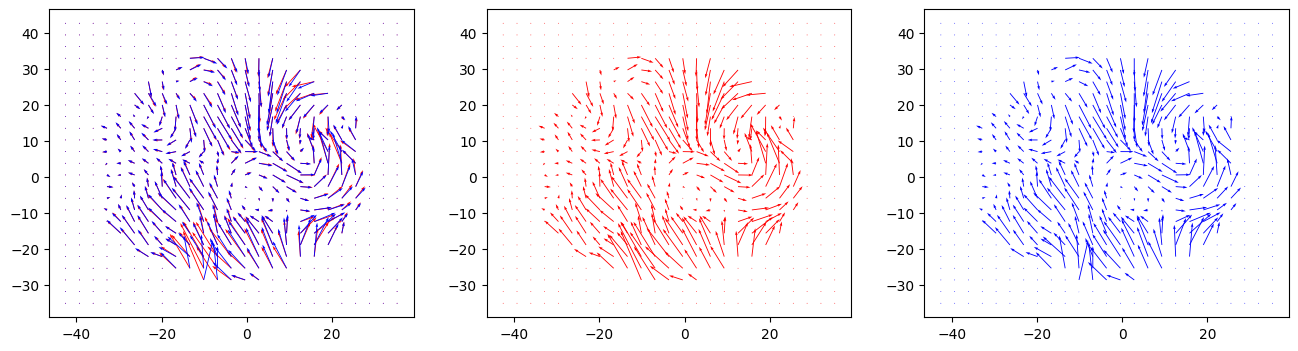

score
616
score:
0.846084272741684
0.846084272741684


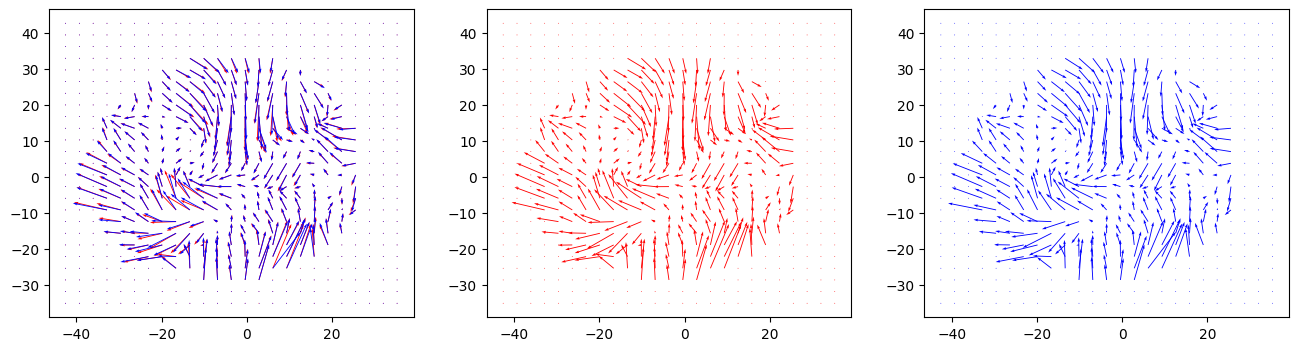

score
616
score:
0.7896225512920935
0.7896225512920935


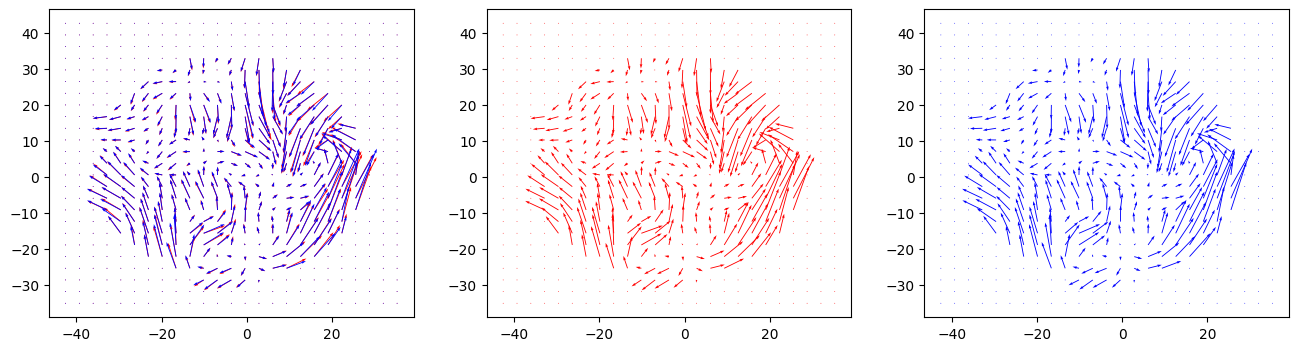

score
618
score:
-1.4321588808829664
-1.4321588808829664


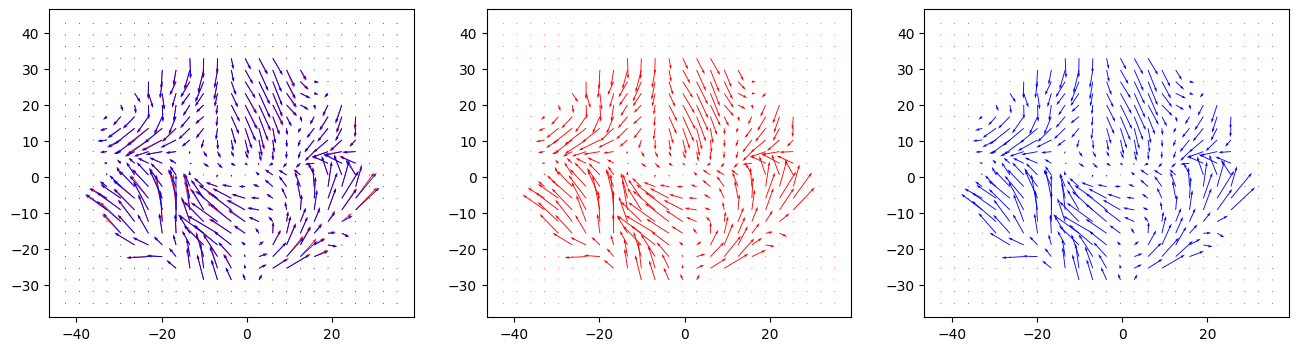

score
620
score:
0.7650472366952225
0.7650472366952225


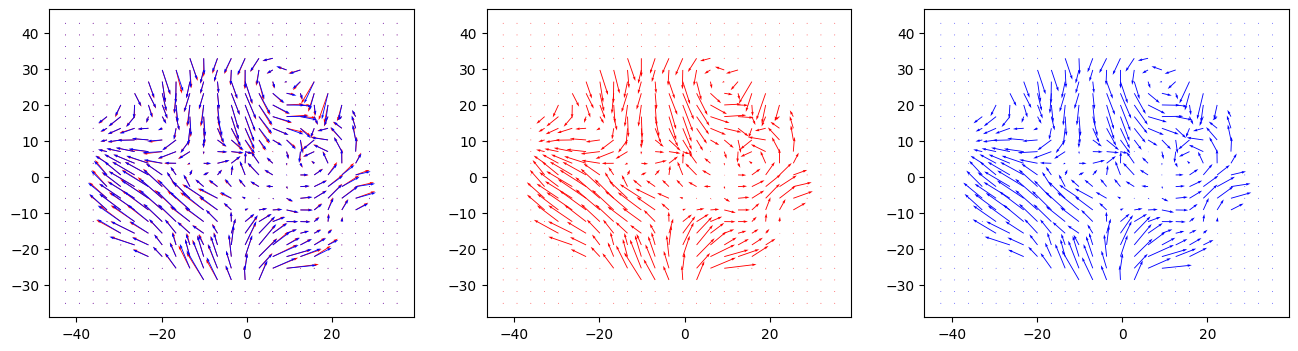

score
620
score:
0.7794946223237337
0.7794946223237337


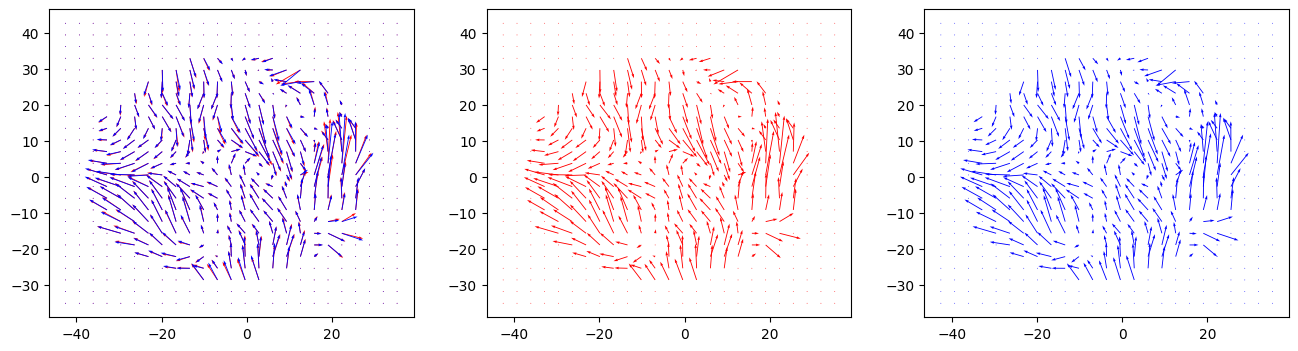

score
618
score:
0.7843432767519751
0.7843432767519751


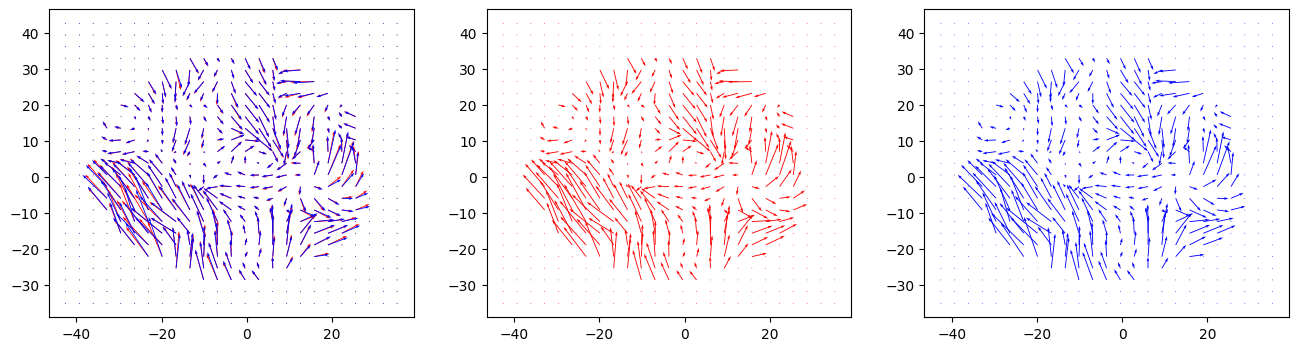

score
618
score:
0.845902883113029
0.845902883113029


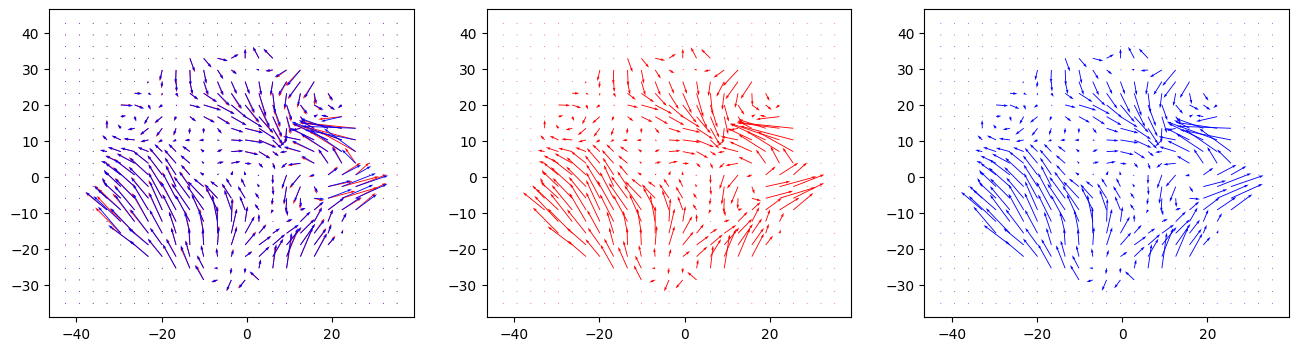

score
616
score:
0.8457228035781791
0.8457228035781791


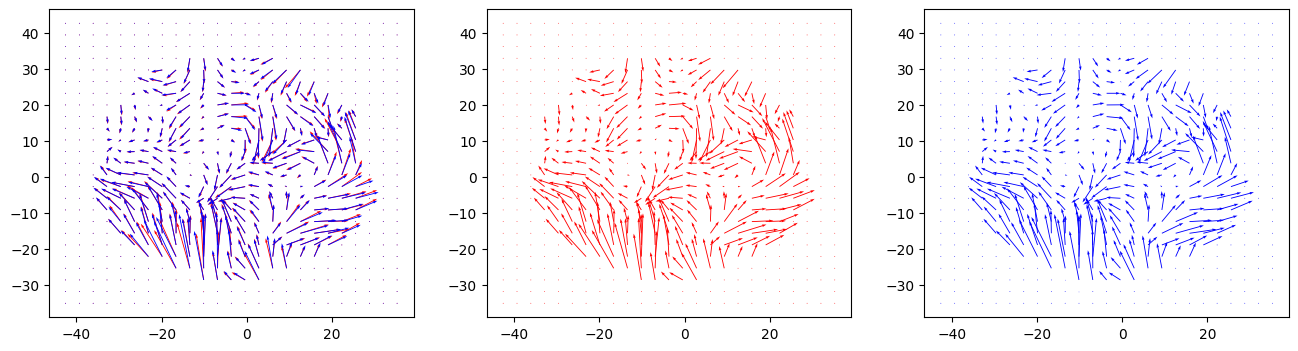

score
620
score:
0.8691673728681509
0.8691673728681509


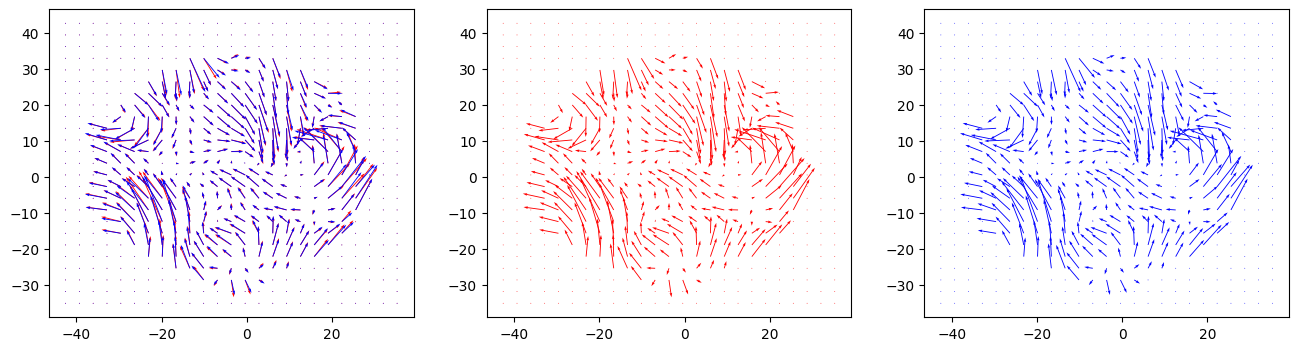

score
618
score:
0.837307159693552
0.837307159693552


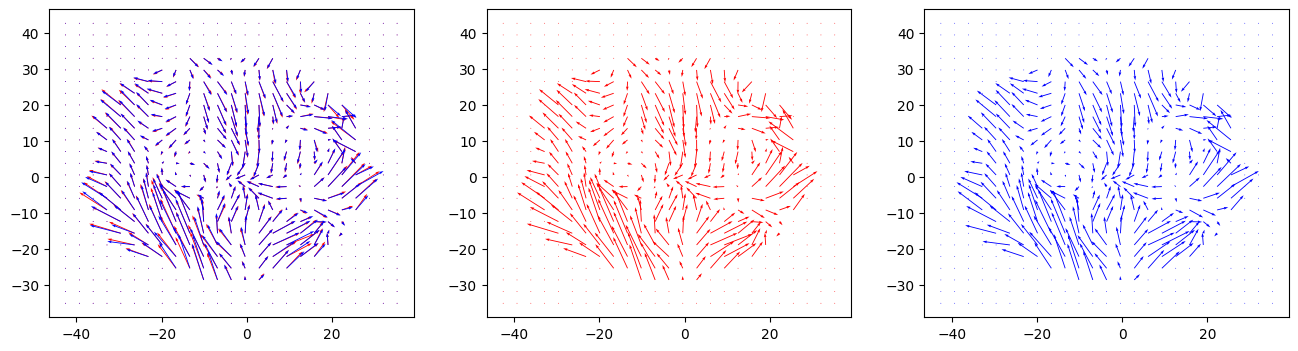

score
616
score:
0.8878369729676142
0.8878369729676142


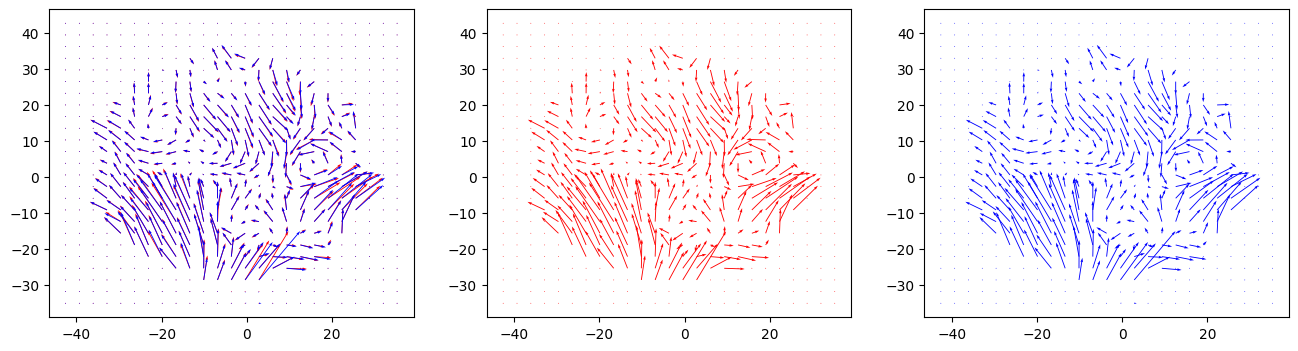

score
616
score:
0.5764073259553746
0.5764073259553746


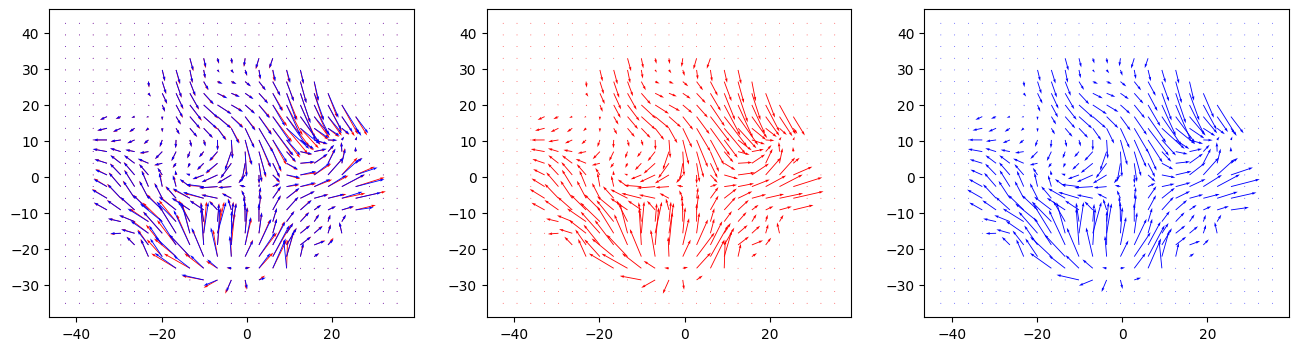

score
620
score:
0.8855163654814178
0.8855163654814178


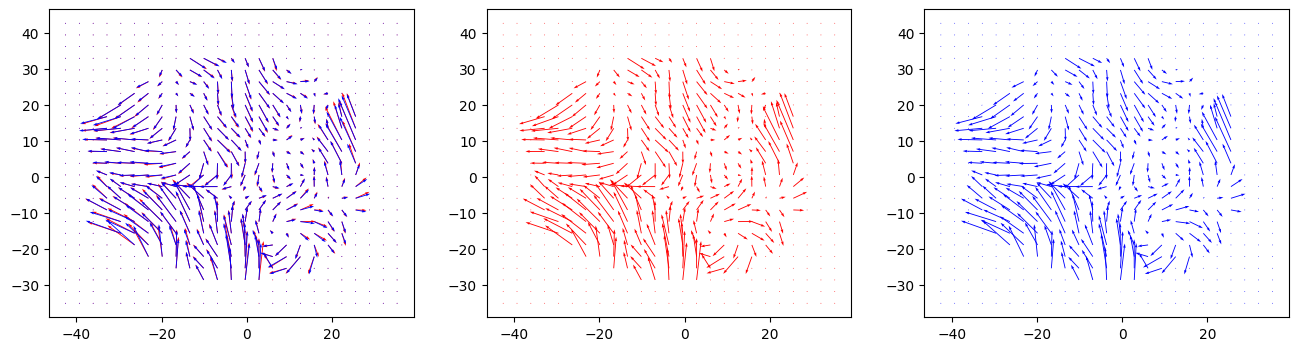

score
620
score:
0.6447068057965555
0.6447068057965555


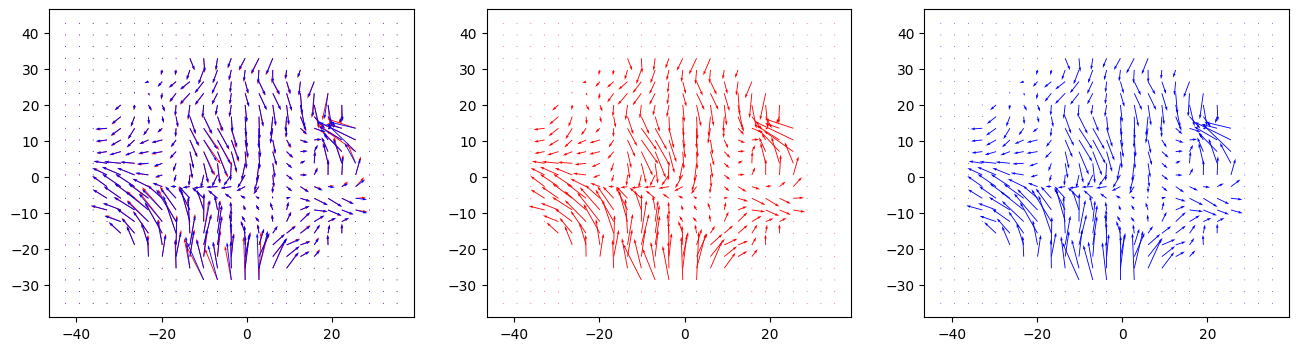

score
616
score:
0.7803322965594083
0.7803322965594083


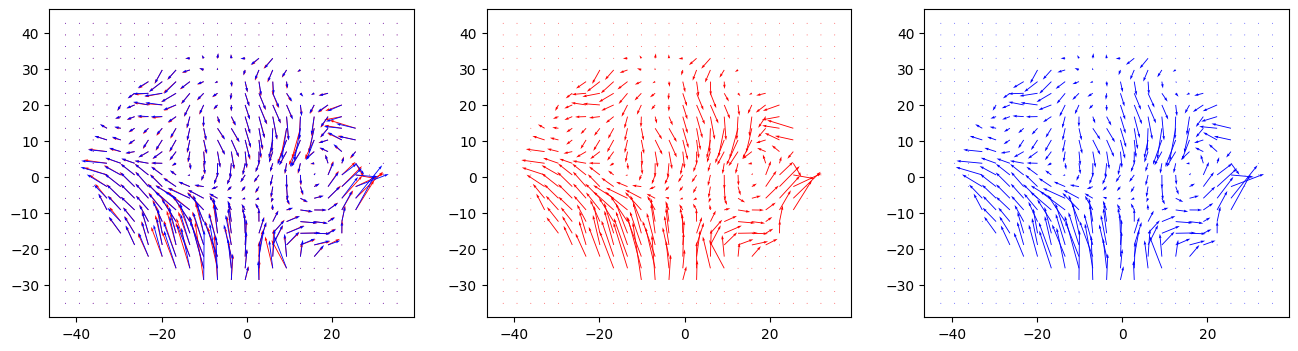

score
616
score:
0.8311208028930608
0.8311208028930608


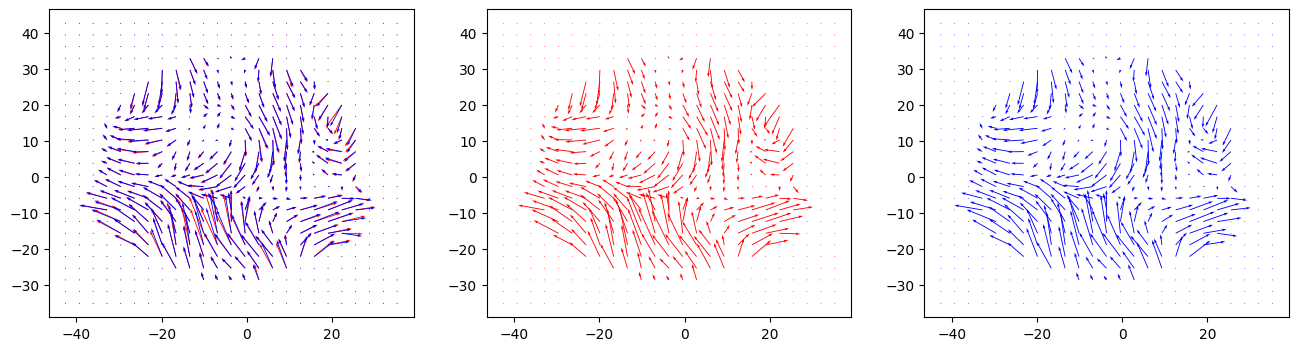

score
616
score:
0.8355071403226264
0.8355071403226264


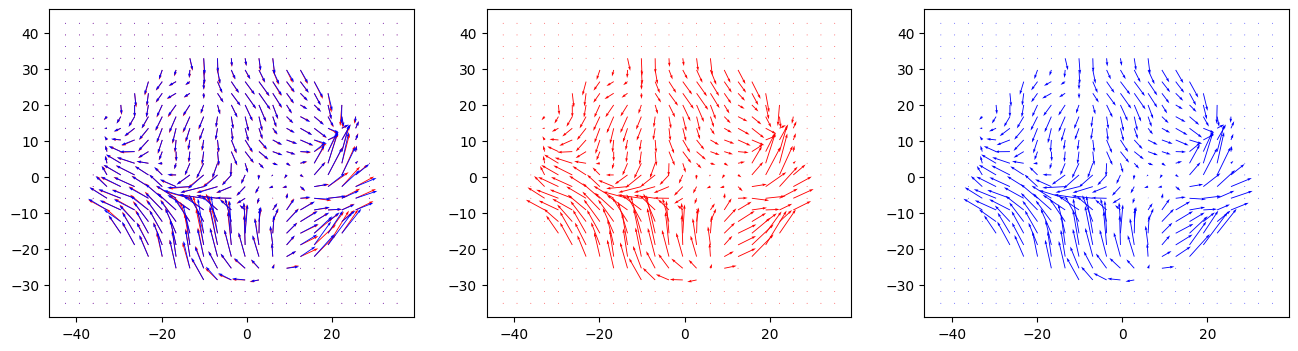

score
620
score:
0.864192141230837
0.864192141230837


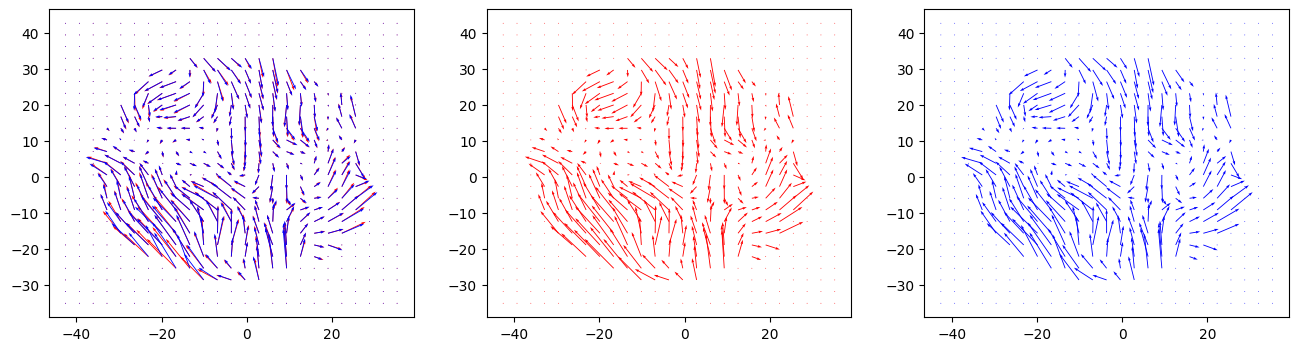

score
618
score:
0.8485674945860294
0.8485674945860294


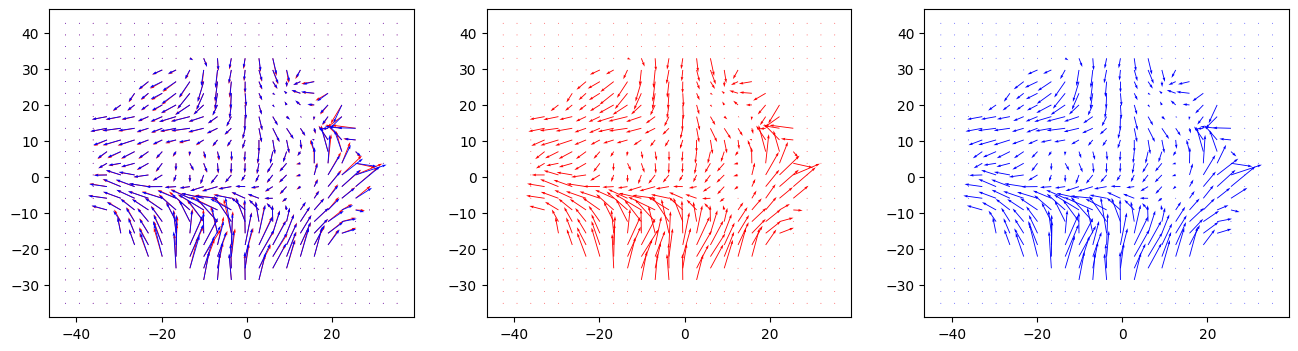

score
618
score:
0.7290116804744042
0.7290116804744042


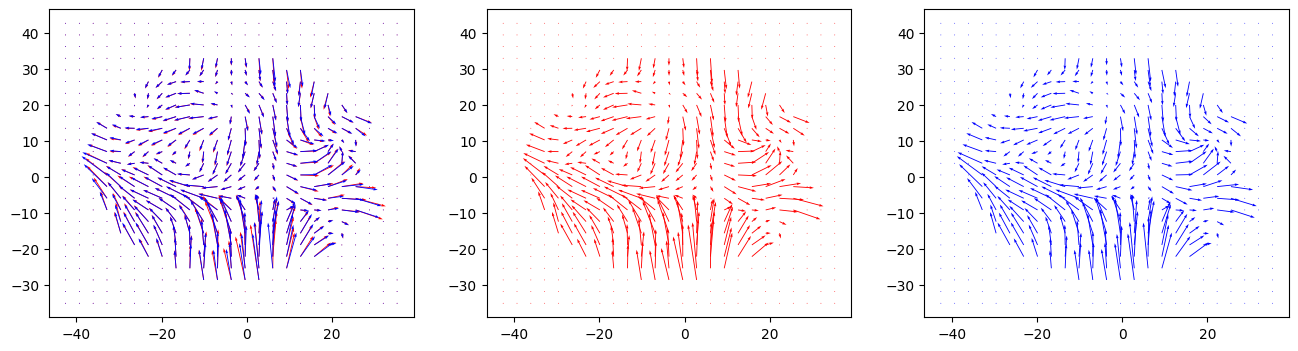

score
618
score:
0.8364551393742587
0.8364551393742587


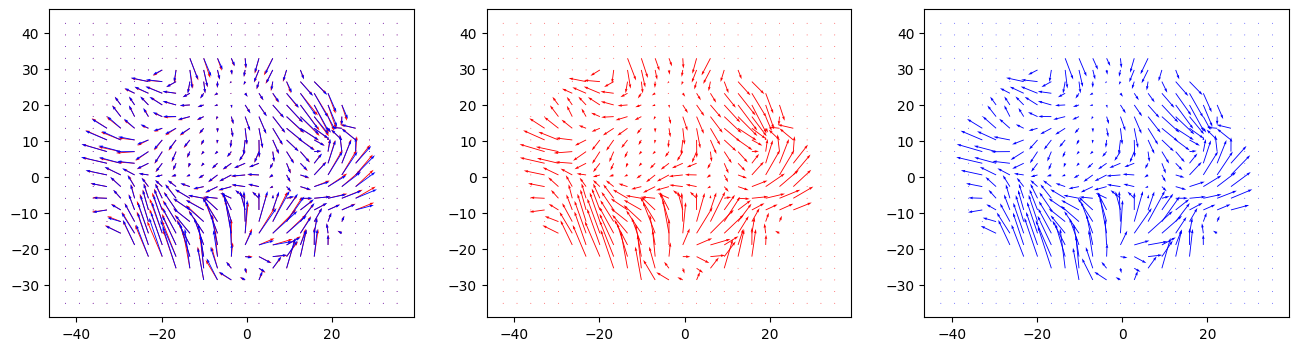

score
616
score:
0.8029805518387101
0.8029805518387101


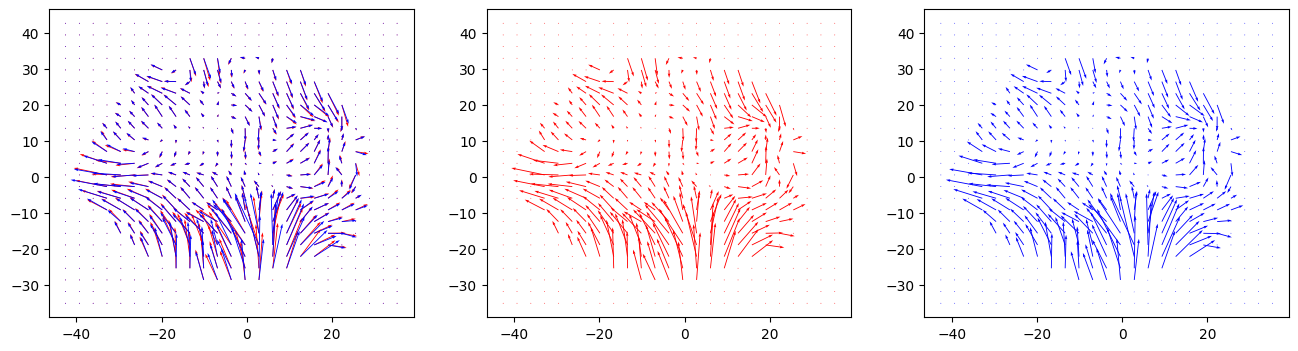

score
616
score:
0.8383623620311725
0.8383623620311725


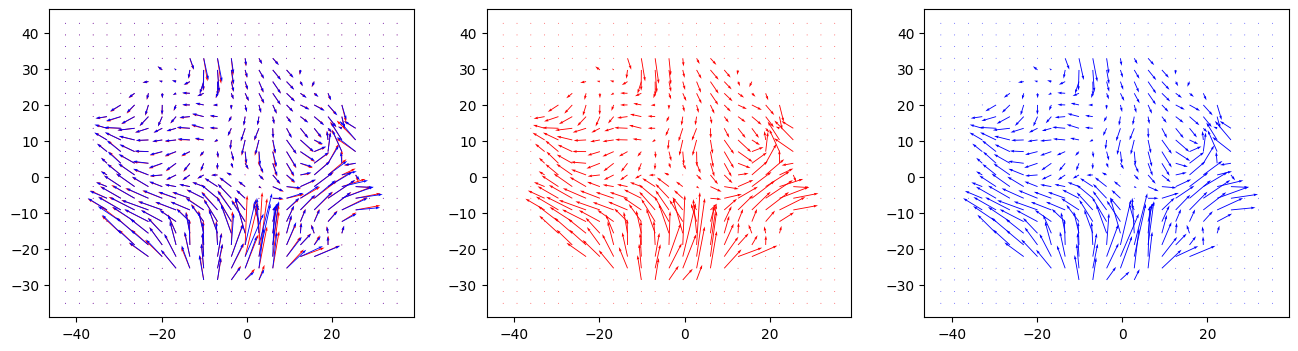

score
618
score:
0.7950838200404682
0.7950838200404682


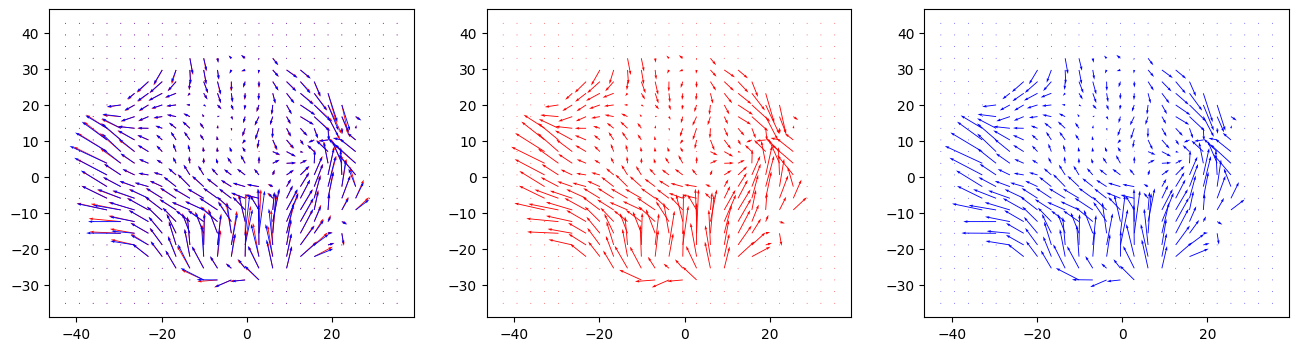

score
618
score:
0.8429988903783331
0.8429988903783331


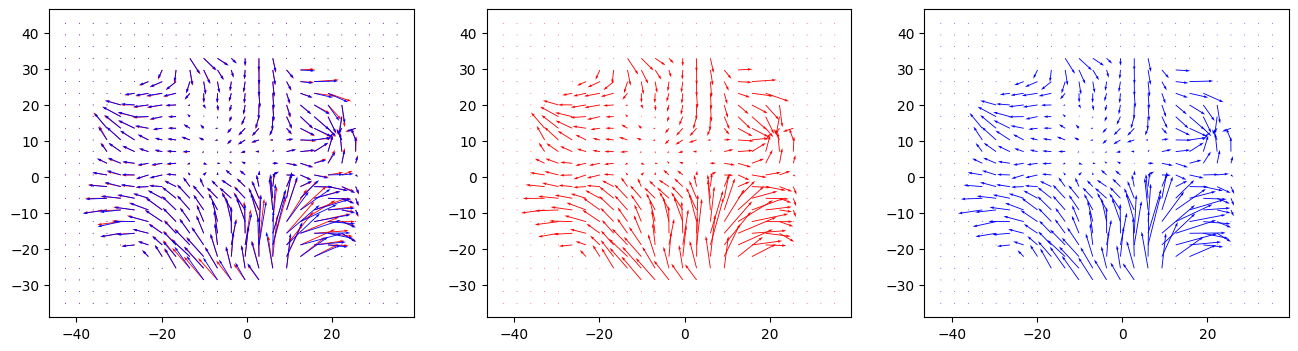

score
616
score:
0.7006227384366625
0.7006227384366625


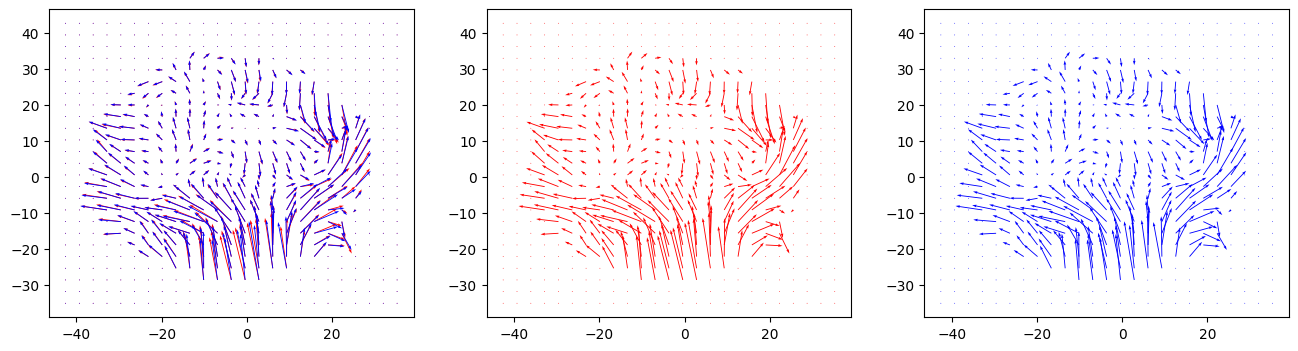

score
618
score:
0.8341762746185205
0.8341762746185205


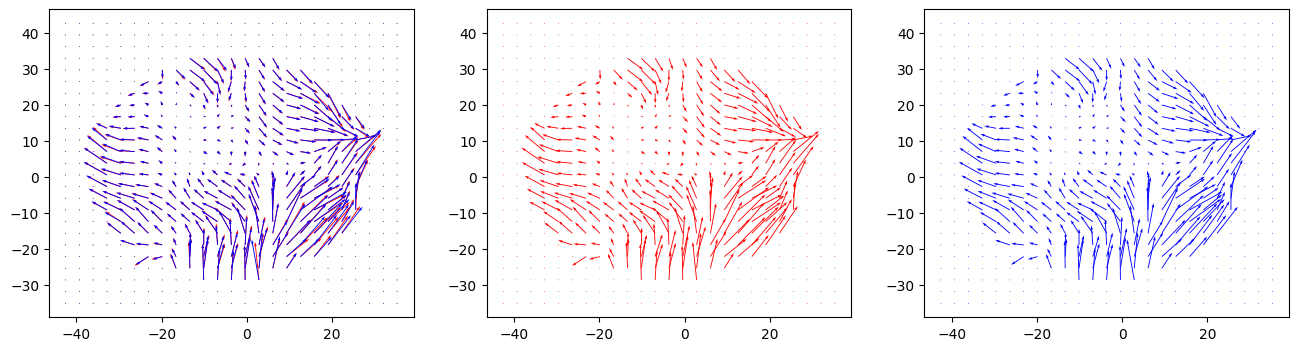

score
618
score:
0.8531210483132502
0.8531210483132502


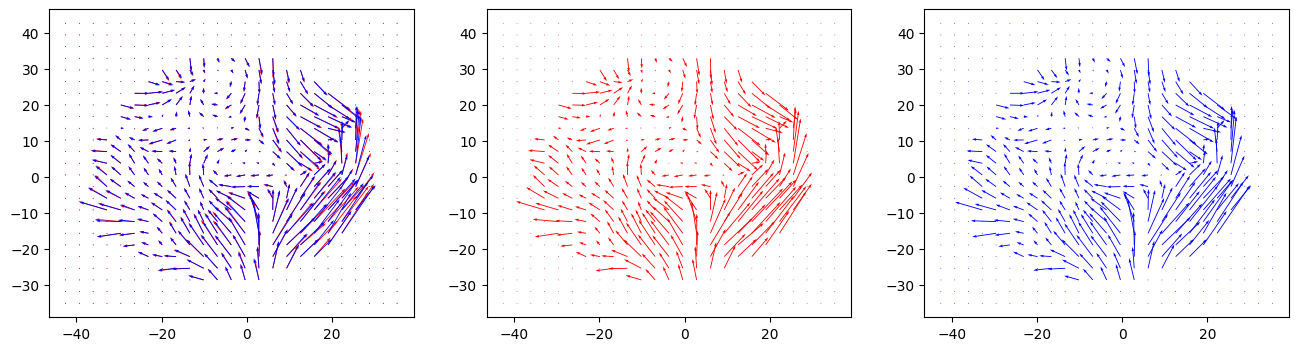

score
616
score:
0.5566482575718593
0.5566482575718593


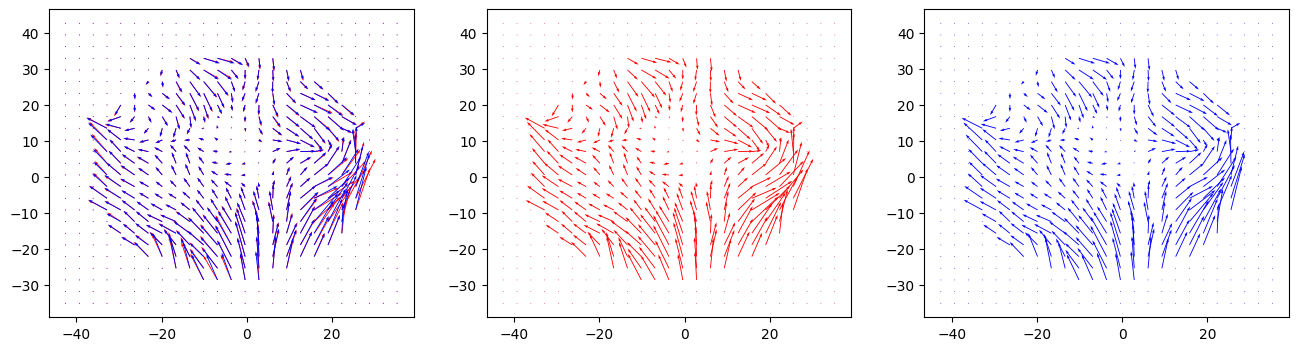

score
616
score:
0.9220137034670881
0.9220137034670881


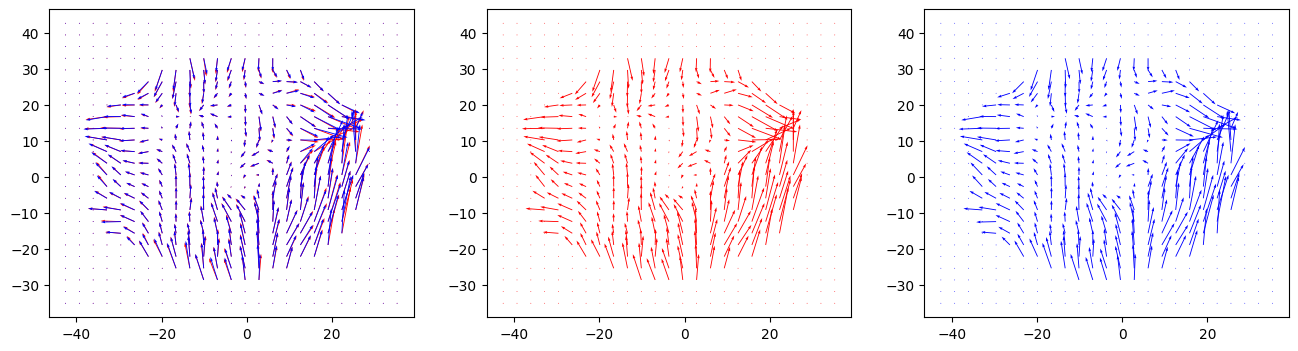

score
618
score:
0.08079015169783849
0.08079015169783849


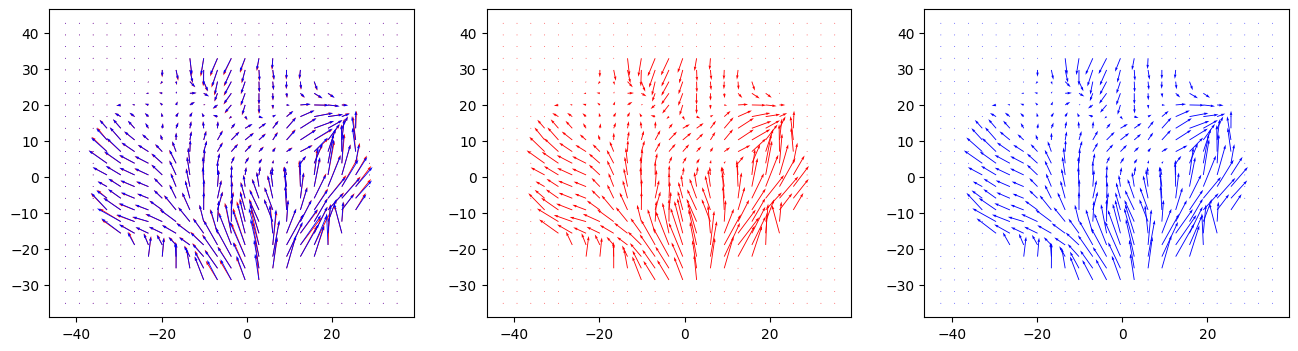

score
616
score:
0.8685701603582072
0.8685701603582072


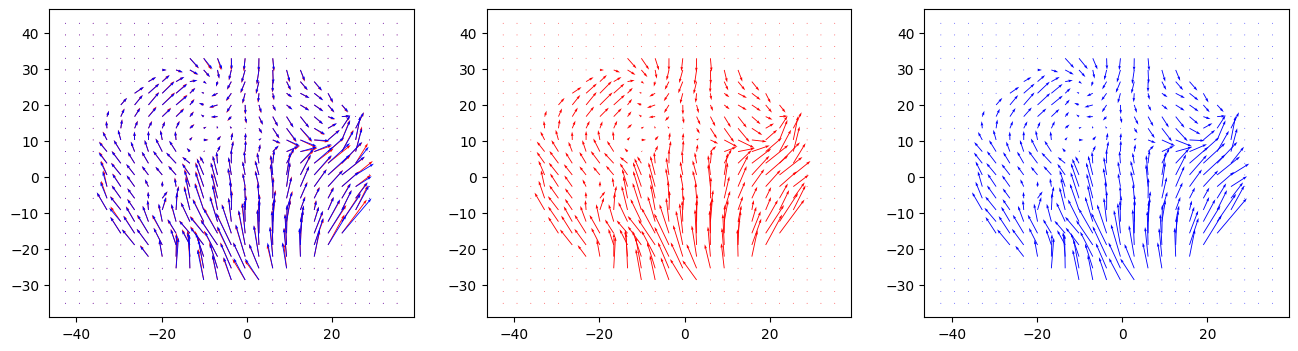

score
618
score:
0.9037206315009223
0.9037206315009223


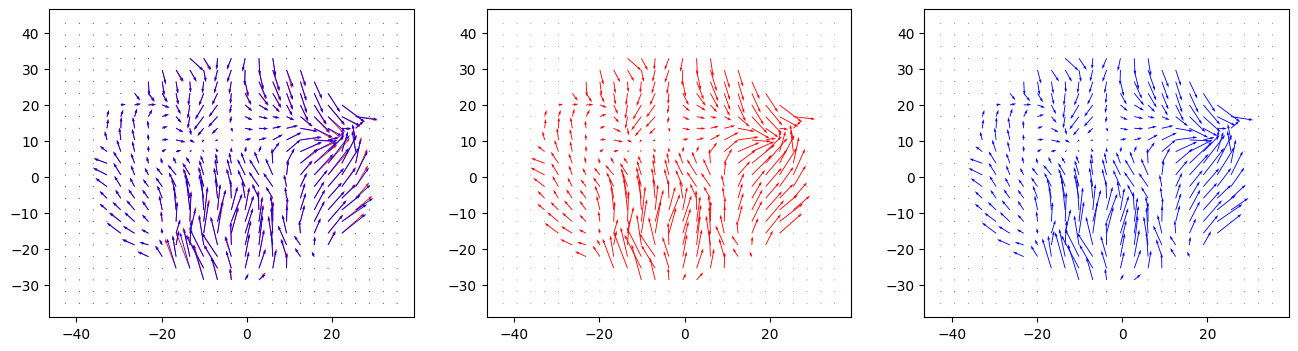

score
620
score:
0.9251791912123924
0.9251791912123924


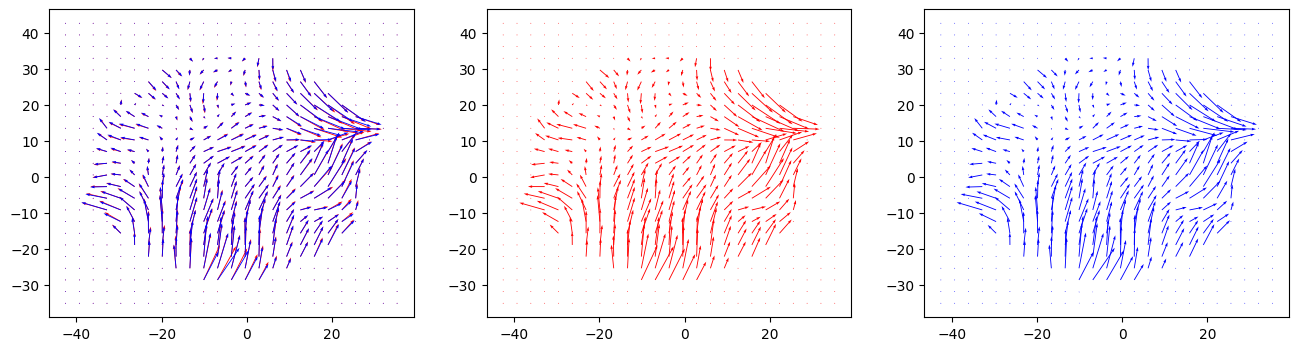

score
618
score:
0.8901773242781599
0.8901773242781599


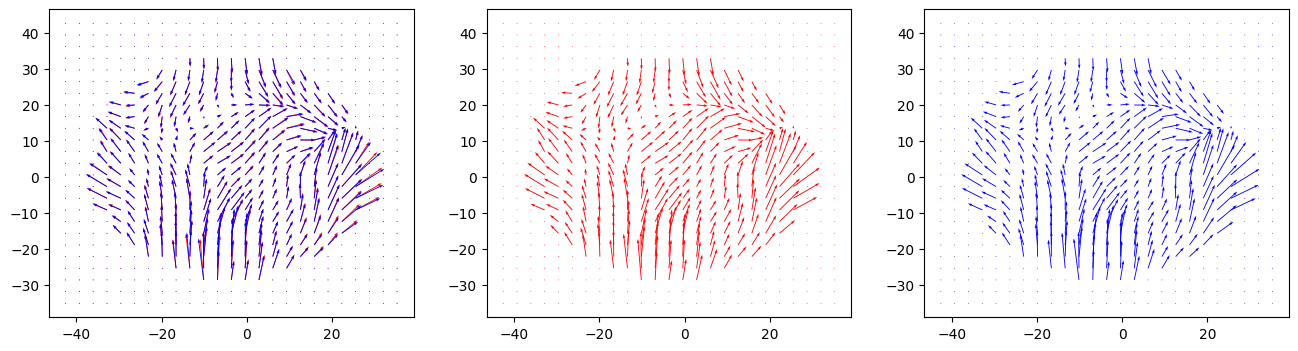

score
616
score:
0.9086167237050429
0.9086167237050429


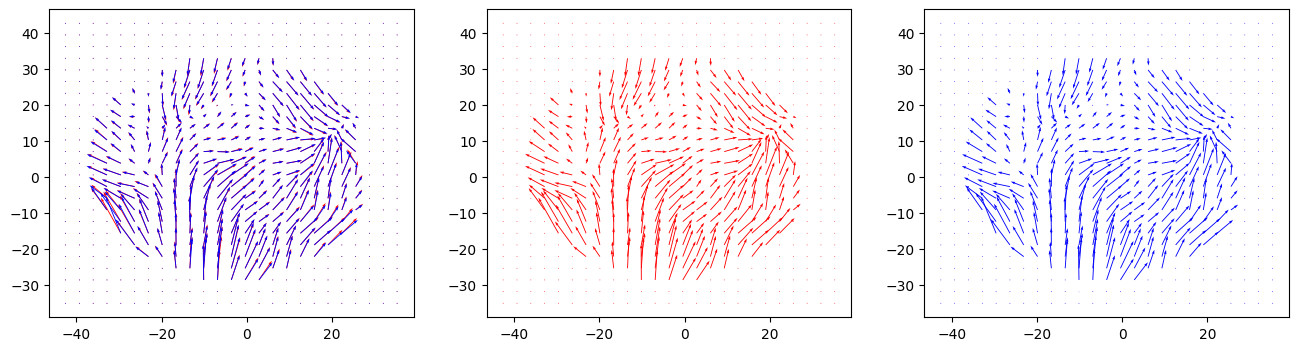

score
618
score:
0.9088173152242037
0.9088173152242037


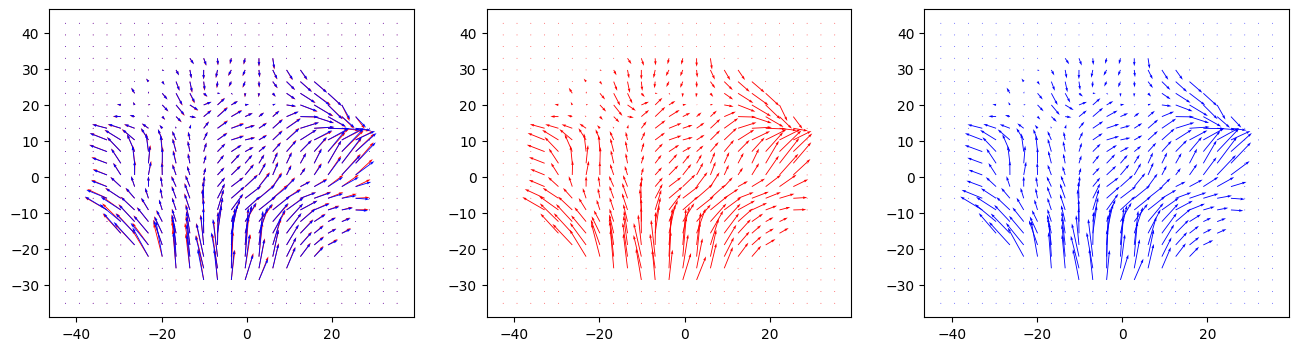

score
618
score:
0.9057300780818326
0.9057300780818326


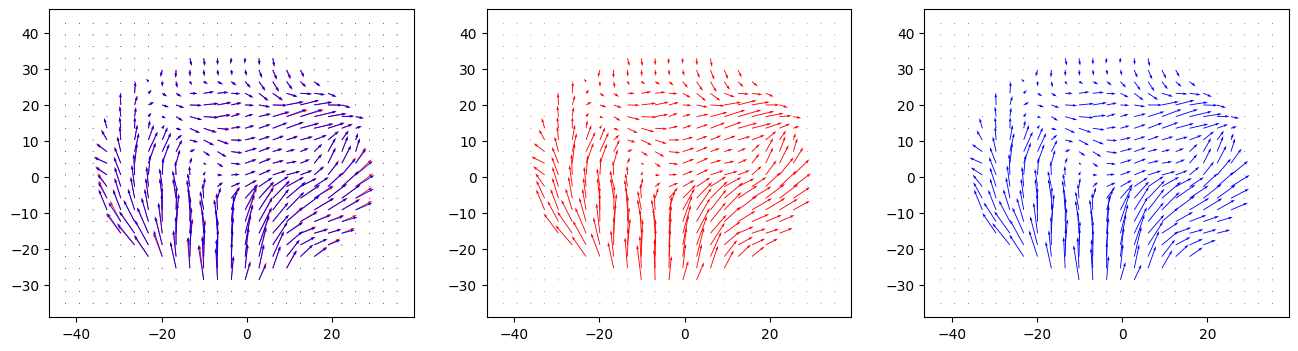

score
618
score:
0.8243074527496032
0.8243074527496032


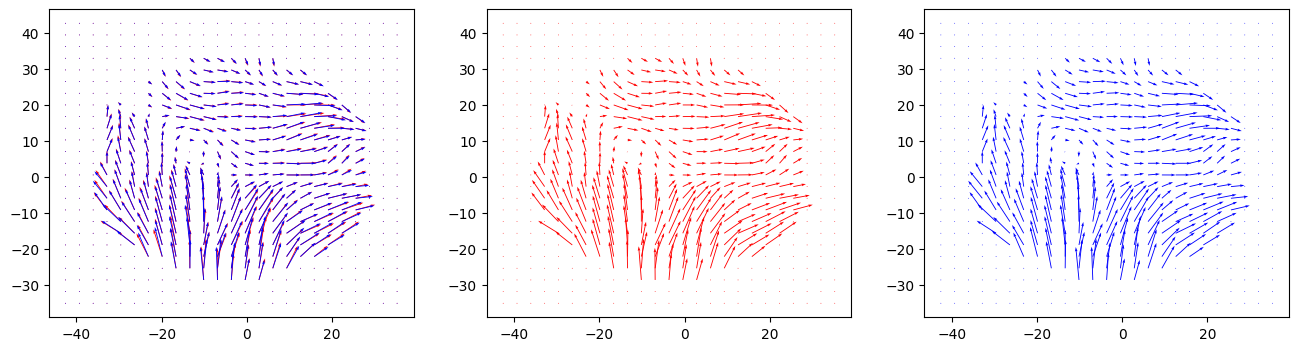

score
620
score:
0.770996443605269
0.770996443605269


In [9]:
for i in range(40):
    u_dot_train[:,:,i,0]
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.quiver(spatial_grid[:,:,1],spatial_gridv[:,:,0],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 2)
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_train[:,:,i,0],u_train[:,:,i,1],color='r')
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.subplot(1, 3, 3)
    #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
    plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.show()
    print('score')
    print(testscore(pltpredict[:,:,i,],u_train[:,:,i,:]))
